# Can you help make sense of the Universe?



# Set up

#### Required Library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features


/Users/youssefberrada/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


#### Path

In [2]:
#data_folder = "/Users/youssefberrada/Downloads/all/"

# Data Acquisition

In [3]:

#train = pd.read_csv(data_folder+'training_set.csv')
#meta_train = pd.read_csv(data_folder+'training_set_metadata.csv')

In [10]:
data_folder = "/Users/youssefberrada/Documents/GitHub/PLAsTiCC-Astronomical-Classification/data/class_data/"
train = pd.read_csv(data_folder+'class_training_set.csv')
meta_train = pd.read_csv(data_folder+'class_training_set_meta.csv')

In [32]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,713,59825.2600,2,9.110147,1.013889,0
1,713,59825.2676,1,7.615042,1.160329,1
2,713,59825.2752,3,6.673631,1.932316,1
3,713,59825.2862,4,5.214194,3.018003,0
4,713,59825.2971,5,12.060948,7.163382,0


# Data Pre-Processing

In [49]:
fcp = {'fft_coefficient': [{'coeff': 0, 'attr': 'abs'},{'coeff': 1, 'attr': 'abs'}],'kurtosis' : None, 'skewness' : None}
def our_feature(df):
    part1 = df[['object_id','mjd','passband','flux']]
    part2 = df[['object_id','mjd','passband','flux_err']]
    part1 = pd.melt(part1,id_vars=['object_id','mjd','passband'],value_name='flux').pivot_table(index =['object_id','mjd'],columns='passband')
    part2 = pd.melt(part2,id_vars=['object_id','mjd','passband'],value_name='flux_err').pivot_table(index =['object_id','mjd'],columns='passband')
    
    time_series_df = part1.join(part2)
    
    def diff_1(series):
        return series.max() - series.min()
    
    def diff_2(series):
        return (series.max() - series.min())/series.mean()
        
    simple_features = time_series_df.groupby('object_id').agg(['mean','std','min','max','skew',diff_1,diff_2])
    
    agg_df_ts = extract_features(df, column_id='object_id', column_sort='mjd', column_kind='passband', column_value = 'flux', default_fc_parameters = fcp, n_jobs=4)
    
    output = pd.merge(simple_features,agg_df_ts,left_index=True,right_index=True)
    
    return output
agg_train = our_feature(train)
agg_train.dropna(inplace=True)

Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.95it/s]
/Users/youssefberrada/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [3]:
fcp = {'fft_coefficient': [{'coeff': 0, 'attr': 'abs'},{'coeff': 1, 'attr': 'abs'}],'kurtosis' : None, 'skewness' : None}

def featurize(df):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    # train[detected==1, mjd_diff:=max(mjd)-min(mjd), by=object_id]


    aggs = {
        'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
        'detected': ['mean'],
        'flux_ratio_sq':['sum','skew'],
        'flux_by_flux_ratio_sq':['sum','skew'],
    }

    agg_df = df.groupby('object_id').agg(aggs)
    new_columns = [
        k + '_' + agg for k in aggs.keys() for agg in aggs[k]
    ]
    agg_df.columns = new_columns
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']
    agg_df['flux_dif2'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_mean']
    agg_df['flux_w_mean'] = agg_df['flux_by_flux_ratio_sq_sum'] / agg_df['flux_ratio_sq_sum']
    agg_df['flux_dif3'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_w_mean']
    # Add more features with 
    agg_df_ts = extract_features(df, column_id='object_id', column_sort='mjd', column_kind='passband', column_value = 'flux', default_fc_parameters = fcp, n_jobs=5)
    # Add smart feature that is suggested here https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69696#410538
    # dt[detected==1, mjd_diff:=max(mjd)-min(mjd), by=object_id]
    df_det = df[df['detected']==1].copy()

    agg_df_mjd = extract_features(df_det, column_id='object_id', column_value = 'mjd', default_fc_parameters = {'maximum':None, 'minimum':None}, n_jobs=5)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd['mjd__minimum']
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    agg_df_ts = pd.merge(agg_df_ts, agg_df_mjd,left_index=True, right_index=True)
    # tsfresh returns a dataframe with an index name='id'
    #agg_df_ts.index.rename('object_id',inplace=True)
    agg_df = pd.merge(agg_df, agg_df_ts,left_index=True, right_index=True)
    return agg_df
    #return agg_df_mjd,agg_df_ts


In [11]:
agg_train= featurize(train)

Feature Extraction: 100%|██████████| 25/25 [00:00<00:00, 90.62it/s]


In [50]:
agg_train.head()

,"(flux, 0, mean)","(flux, 0, std)","(flux, 0, min)","(flux, 0, max)","(flux, 0, skew)","(flux, 0, diff_1)","(flux, 0, diff_2)","(flux, 1, mean)","(flux, 1, std)","(flux, 1, min)",...,3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,4__skewness,"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_1__attr_""abs""",5__kurtosis,5__skewness
object_id,,,,,,,,,,,,,,,,,,,,,
713,-2.720398,7.113509,-14.735178,14.509829,0.260052,29.245007,-10.750268,-1.019804,5.712334,-11.715749,...,-1.142896,-0.167176,50.414646,203.892482,-1.190245,-0.064134,100.473776,143.963093,-0.797047,0.218182
730,-0.048080,1.828872,-3.459960,5.942166,0.356910,9.402126,-195.550011,0.141057,1.807229,-3.393080,...,7.125665,2.662075,219.745132,202.532898,6.081065,2.537802,231.509177,199.286370,3.583130,1.680352
745,1.797523,4.374445,-3.874349,18.014029,2.023211,21.888378,12.176967,5.717394,25.964659,-3.618410,...,16.392533,3.751603,735.528417,680.055280,13.747434,3.476420,591.037583,523.503586,12.134629,3.170857
1124,0.660948,2.360084,-6.804703,5.330927,-0.332169,12.135630,18.360947,4.634637,8.107525,-2.622109,...,14.095862,3.603208,574.553907,524.107264,16.377058,3.904008,393.114268,357.907185,14.434470,3.657305
1227,1.287449,8.727326,-3.818113,71.678154,7.585756,75.496267,58.640181,0.228660,1.694776,-2.582174,...,-0.497384,-0.043294,30.384898,23.255760,3.266776,0.247423,25.692383,78.643093,1.290034,0.535841


In [12]:
full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

if 'target' in full_train:
    y = full_train['target']
    #del full_train['target']
classes = sorted(y.unique())

class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']
    
train_mean = full_train.mean(axis=0)
full_train.fillna(0, inplace=True)

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


# Data Analysis

#### Light GBM

In [52]:
lgb_params_old = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 14,
    'metric': 'multi_logloss',
    'learning_rate': 0.03,
    'subsample': .9,
    'colsample_bytree': 0.5,
    'reg_alpha': .01,
    'reg_lambda': .01,
    'min_split_gain': 0.01,
    'min_child_weight': 10,
    'n_estimators': 1000,
    'silent': -1,
    'verbose': -1,
    'max_depth': 3
}
lgb_params = {
            'device': 'cpu', 
            'objective': 'multiclass', 
            'num_class': 14, 
            'boosting_type': 'gbdt', 
            'n_jobs': -1, 
            'max_depth': 6, 
            'n_estimators': 1000, 
            'subsample_freq': 2, 
            'subsample_for_bin': 5000, 
            'min_data_per_group': 100, 
            'max_cat_to_onehot': 4, 
            'cat_l2': 1.0, 
            'cat_smooth': 59.5, 
            'max_cat_threshold': 32, 
            'metric_freq': 10, 
            'verbosity': -1, 
            'metric': 'multi_logloss', 
            'xgboost_dart_mode': False, 
            'uniform_drop': False, 
            'colsample_bytree': 0.5, 
            'drop_rate': 0.173, 
            'learning_rate': 0.025, 
            'max_drop': 5, 
            'min_child_samples': 10, 
            'min_child_weight': 200.0, 
            'min_split_gain': 0.01, 
            'num_leaves': 7, 
            'reg_alpha': 0.1, 
            'reg_lambda': 0.00023, 
            'skip_drop': 0.44, 
            'subsample': 0.75}

In [53]:
def multi_weighted_logloss(y_true, y_preds):
    """
    this function implements a multi logloss 
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss
def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False



In [54]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clfs = []
importances = pd.DataFrame()


# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}

oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
    val_x, val_y = full_train.iloc[val_], y.iloc[val_]

    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights)
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    print(multi_weighted_logloss(val_y, oof_preds[val_, :]))

    imp_df = pd.DataFrame()
    imp_df['feature'] = full_train.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0)

    clfs.append(clf)



Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.84756	training's wloss: 0.841867	valid_1's multi_logloss: 1.24269	valid_1's wloss: 1.22953
[200]	training's multi_logloss: 0.533191	training's wloss: 0.523887	valid_1's multi_logloss: 0.98448	valid_1's wloss: 1.00622
[300]	training's multi_logloss: 0.408074	training's wloss: 0.39798	valid_1's multi_logloss: 0.892373	valid_1's wloss: 0.954667
[400]	training's multi_logloss: 0.337639	training's wloss: 0.327435	valid_1's multi_logloss: 0.848476	valid_1's wloss: 0.945028
Early stopping, best iteration is:
[410]	training's multi_logloss: 0.331925	training's wloss: 0.321641	valid_1's multi_logloss: 0.844959	valid_1's wloss: 0.944188
0.9441878057076823
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.849668	training's wloss: 0.851955	valid_1's multi_logloss: 1.21943	valid_1's wloss: 1.13263
[200]	training's multi_logloss: 0.532732	training's wloss: 0.5

In [57]:
def predict_chunk(df_, clfs_, meta_, features, train_mean):
    # Group by object id    
    agg_ = our_feature(df_)
    # Merge with meta data
    full_test = agg_.reset_index().merge(
        right=meta_,
        how='left',
        on='object_id'
    )

    full_test = full_test.fillna(0)
    # Make predictions
    preds_ = None
    for clf in clfs_:
        if preds_ is None:
            preds_ = clf.predict_proba(full_test[features]) / len(clfs_)
        else:
            preds_ += clf.predict_proba(full_test[features]) / len(clfs_)

    # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])

    # Create DataFrame from predictions
    preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
    preds_df_['object_id'] = full_test['object_id']
    preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    return preds_df_

In [55]:
def predict_chunk(df_, clfs_, meta_, features, train_mean):
    # Group by object id    
    agg_ = featurize(df_)
    # Merge with meta data
    full_test = agg_.reset_index().merge(
        right=meta_,
        how='left',
        on='object_id'
    )

    full_test = full_test.fillna(0)
    # Make predictions
    preds_ = None
    for clf in clfs_:
        if preds_ is None:
            preds_ = clf.predict_proba(full_test[features]) / len(clfs_)
        else:
            preds_ += clf.predict_proba(full_test[features]) / len(clfs_)

    # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])

    # Create DataFrame from predictions
    preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
    preds_df_['object_id'] = full_test['object_id']
    preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    return preds_df_

In [58]:

#meta_test = pd.read_csv(data_folder+'test_set_metadata.csv')
meta_test = pd.read_csv(data_folder+'class_test_set_meta.csv').drop('target',axis=1)
meta_test_full = pd.read_csv(data_folder+'class_test_set_meta.csv')

In [59]:
meta_test.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017
1,1920,149.414062,3.433834,234.919132,42.245550,1,0.3088,0.3229,0.3360,41.1401,0.027
2,2624,346.655182,-63.260487,320.952196,-50.040935,1,0.0000,0.0000,0.0000,NaN,0.019
3,2677,53.964844,-28.630989,225.142950,-53.813613,1,0.0000,0.0000,0.0000,NaN,0.009
4,3041,346.130127,-63.072620,321.423103,-50.042305,1,0.1069,0.1274,0.0198,38.8800,0.020


In [61]:

# meta_test.set_index('object_id',inplace=True)
import time

start = time.time()
chunks = 5000000
remain_df = None

for i_c, df in enumerate(pd.read_csv(data_folder+'class_test_set.csv', chunksize=chunks, iterator=True)):
    unique_ids = np.unique(df['object_id'])
    new_remain_df = df.loc[df['object_id'] == unique_ids[-1]].copy()
    if remain_df is None:
        df = df.loc[df['object_id'].isin(unique_ids[:-1])]
    else:
        df = pd.concat([remain_df, df.loc[df['object_id'].isin(unique_ids[:-1])]], axis=0)
    # Create remaining samples df
    remain_df = new_remain_df
    preds_df = predict_chunk(df_=df,
                             clfs_=clfs,
                             meta_=meta_test,
                             features=full_train.columns,
                             train_mean=train_mean)

    if i_c == 0:
        preds_df.to_csv(data_folder+'predictions.csv', header=True, mode='a', index=False)
    else:
        preds_df.to_csv(data_folder+'predictions.csv', header=False, mode='a', index=False)

    del preds_df
    
    print('%15d done in %5.1f minutes' % (chunks * (i_c + 1), (time.time() - start) / 60), flush=True)

# Compute last object in remain_df
preds_df = predict_chunk(df_=remain_df,
                         clfs_=clfs,
                         meta_=meta_test,
                         features=full_train.columns,
                         train_mean=train_mean)

preds_df.to_csv(data_folder+'predictions.csv', header=False, mode='a', index=False)

Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  6.26it/s]
/Users/youssefberrada/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


        5000000 done in   0.8 minutes


Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 714.37it/s]
/Users/youssefberrada/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


# Data Evaluation

### Loss Function 

In [17]:
preds_df

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,object_id,class_99
0,0.000556,0.000642,0.000247,0.000505,0.000576,0.000107,0.000387,0.000356,0.995406,0.000306,0.000231,0.000349,0.000214,0.000118,130739978,0.14


In [18]:
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))

MULTI WEIGHTED LOG LOSS : 0.77363 


# Data Presentation

### Confusion Matrix

### Plot the Confusion Matrix

Normalized confusion matrix


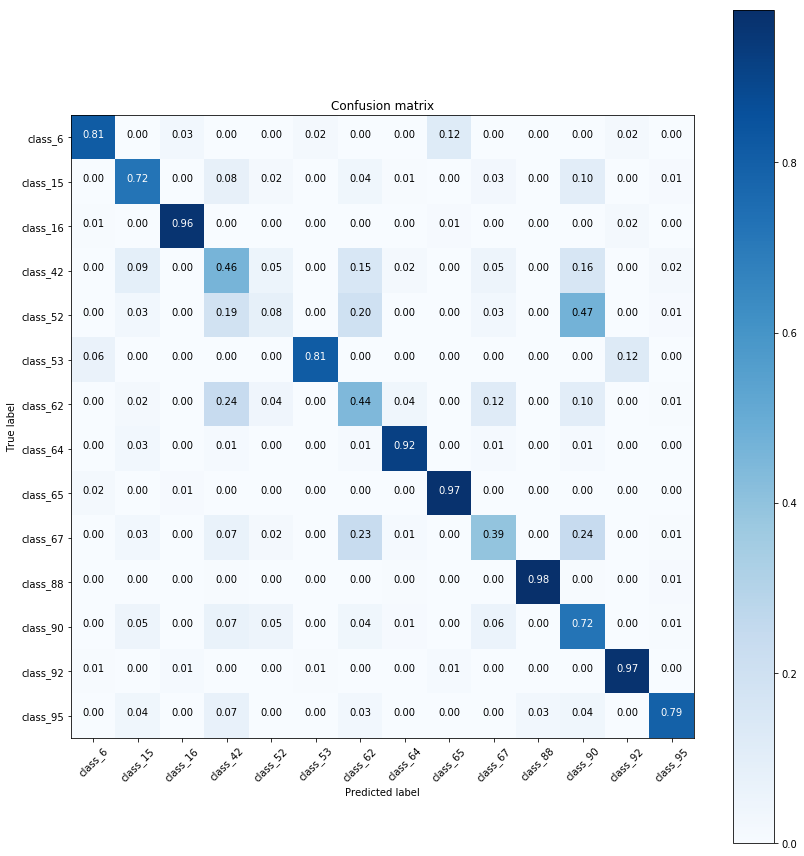

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [ ]:
from sklearn.metrics import recall_score
recall_sc = recall_score(y_map, np.argmax(oof_preds,axis=-1), average='macro')
recall_sc

In [ ]:
from sklearn.metrics import f1_score
f1_sc = f1_score(y_map, np.argmax(oof_preds,axis=-1), average='macro')
f1_sc

# Test Set Confusion Matrix

In [62]:
pred= pd.read_csv(data_folder+'predictions.csv')

In [63]:
y = np.array(meta_test_full.target)
unique_y =np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])



/Users/youssefberrada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/youssefberrada/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Normalized confusion matrix


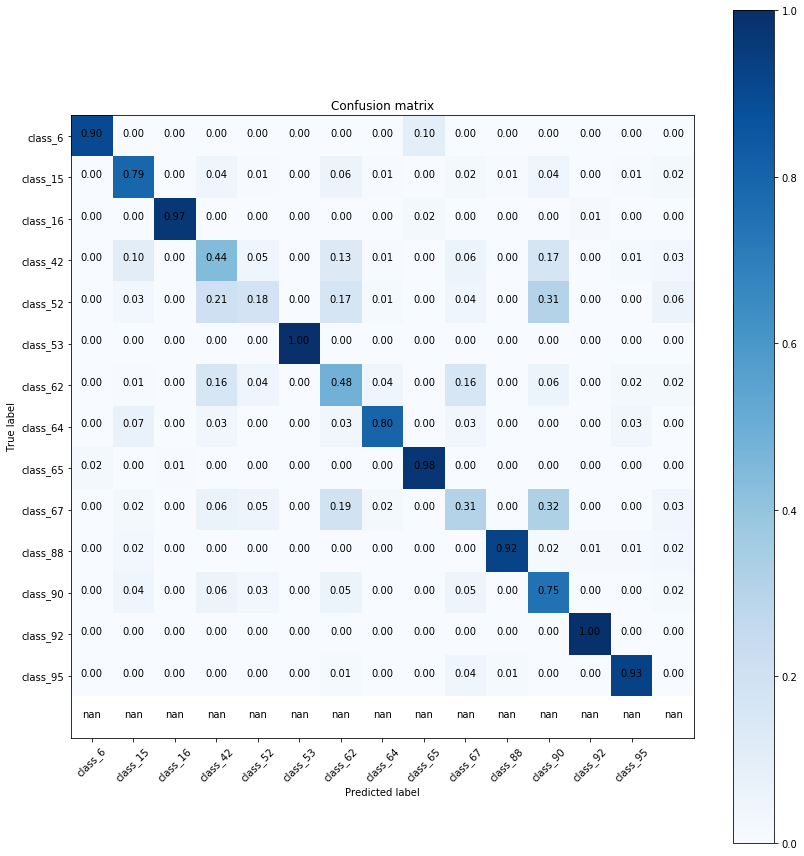

In [64]:
# Sheng Features
cnf_matrix = confusion_matrix(y_map, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

/Users/youssefberrada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/youssefberrada/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Normalized confusion matrix


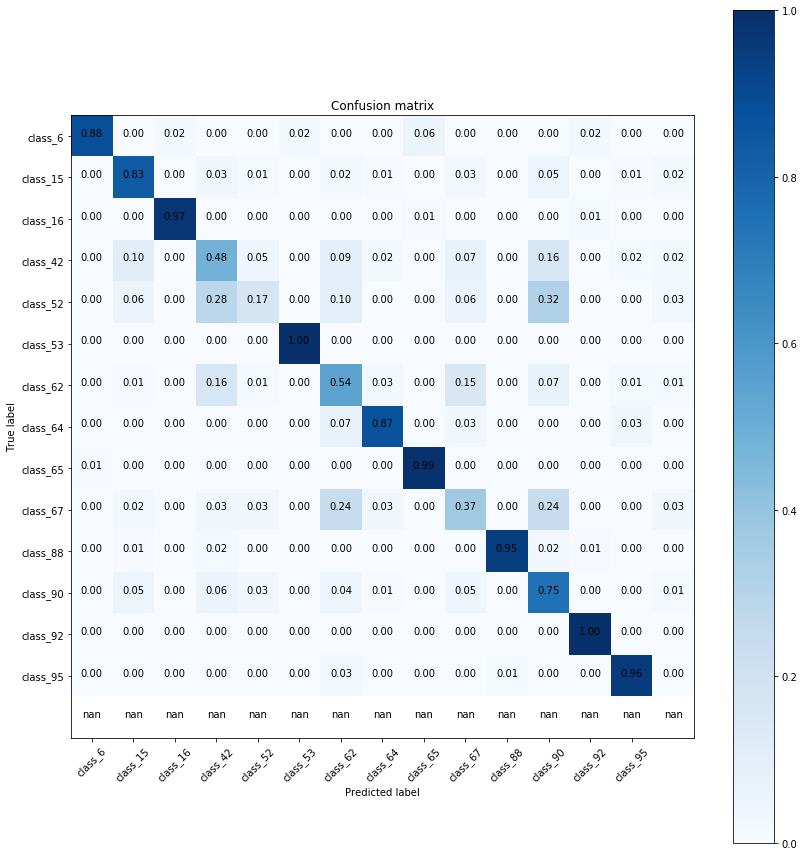

In [30]:
# Youssef's Features
cnf_matrix = confusion_matrix(y_map, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')